In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

meta_path   = "/content/drive/MyDrive/dataset-amazon-electronics/meta_All_Beauty.jsonl"


In [ ]:
reviews_path = "/content/drive/MyDrive/dataset-amazon-electronics/All_Beauty.jsonl"


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import re
import json
import ast

In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  int64         
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
 10  review_text_len    701528 non-null  int64         
 11  review_title_len   701528 non-null  int64         
 12  helpful_ratio      701528 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), i

In [ ]:


# --- 0. Setup and NLTK/spaCy Download ---
print("\n--- 0. Setup and NLTK/spaCy Download ---")
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")
try:
    nltk.data.find("sentiment/vader_lexicon")
except LookupError:
    nltk.download("vader_lexicon")

try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# --- 1. Data Loading and Initial Preprocessing ---
print("\n--- 1. Data Loading and Initial Preprocessing ---")

#reviews_path = "./upload/first10kreviewsall_beauty.jsonl" # Adjust path for local execution
#meta_path = "./upload/first10kmetaall_beauty.jsonl" # Adjust path for local execution

df_reviews = pd.read_json(reviews_path, lines=True)
df_meta = pd.read_json(meta_path, lines=True)

df_meta.drop(columns=["bought_together"], inplace=True, errors="ignore")
df_reviews["timestamp"] = pd.to_datetime(df_reviews["timestamp"])

# --- 2. Feature Engineering ---
print("\n--- 2. Feature Engineering ---")

df_reviews["review_text_len"] = df_reviews["text"].apply(lambda x: len(str(x)))
df_reviews["review_title_len"] = df_reviews["title"].apply(lambda x: len(str(x)))
df_reviews["helpful_ratio"] = df_reviews.apply(lambda row: row["helpful_vote"] / (row["helpful_vote"] + 1e-6) if row["helpful_vote"] > 0 else 0, axis=1)

df_meta["price_imputed"] = df_meta["price"].fillna(df_meta["price"].median())
df_merged = pd.merge(df_reviews, df_meta, on="parent_asin", how="left", suffixes=["_review", "_meta"])

# --- 3. Advanced Feature Engineering and Anomaly Detection Modules (without model training) ---
print("\n3. Advanced Feature Engineering and Anomaly Detection Modules ---")

# 3.1. Sentiment Analysis
print("\n3.1. Sentiment Analysis...")
sia = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)["compound"]
    return 0.0
df_merged["sentiment_score"] = df_merged["text"].apply(get_sentiment_score)
print("Sentiment analysis complete.")

# 3.2. Advanced Price Anomaly Detection (Rule-based for this script)
print("\n3.2. Advanced Price Anomaly Detection...")
df_price_temp = df_merged.dropna(subset=["price_imputed"]).copy()
# Simple rule-based anomaly detection for visualization purposes
Q1 = df_price_temp["price_imputed"].quantile(0.25)
Q3 = df_price_temp["price_imputed"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_merged["price_anomaly_flag"] = ((df_merged["price_imputed"] < lower_bound) | (df_merged["price_imputed"] > upper_bound)).astype(int)
print("Price anomaly detection complete.")


--- 0. Setup and NLTK/spaCy Download ---


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...



--- 1. Data Loading and Initial Preprocessing ---

--- 2. Feature Engineering ---

3. Advanced Feature Engineering and Anomaly Detection Modules ---

3.1. Sentiment Analysis...
Sentiment analysis complete.

3.2. Advanced Price Anomaly Detection...
Price anomaly detection complete.


In [ ]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112590 entries, 0 to 112589
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   main_category   112590 non-null  object 
 1   title           112590 non-null  object 
 2   average_rating  112590 non-null  float64
 3   rating_number   112590 non-null  int64  
 4   features        112590 non-null  object 
 5   description     112590 non-null  object 
 6   price           17704 non-null   float64
 7   images          112590 non-null  object 
 8   videos          112590 non-null  object 
 9   store           101259 non-null  object 
 10  categories      112590 non-null  object 
 11  details         112590 non-null  object 
 12  parent_asin     112590 non-null  object 
 13  price_imputed   112590 non-null  float64
dtypes: float64(3), int64(1), object(10)
memory usage: 12.0+ MB


In [ ]:
# 3.3. NLP-based Brand and Feature Consistency Checks
print("\n3.3. NLP-based Brand and Feature Consistency Checks...")

def safe_parse_list_string(text):
    if text is None: return []
    if isinstance(text, (np.ndarray, pd.Series)):
        if text.size == 0: return []
        # Handle non-empty array-like objects by converting to list
        return list(text)

    # Check if text is a scalar before calling pd.isna
    if not np.isscalar(text):
        text = str(text)

    if pd.isna(text): return [] # Handle NaN after array/series check
    if isinstance(text, list): return text # Already a list

    text = str(text).strip()
    if text.startswith("[") and text.endswith("]"):
        try:
            return ast.literal_eval(text)
        except (ValueError, SyntaxError):
            pass
    return [text] # Return as a list containing the single item


3.3. NLP-based Brand and Feature Consistency Checks...


In [ ]:
def check_brand_consistency_simple(row):
    title = str(row["title_meta"]).lower()
    description = str(row["description"]).lower()
    store = str(row["store"]).lower() if pd.notna(row["store"]) else ""
    details_brand = ""
    if isinstance(row["details"], str):
        try:
            details_dict = ast.literal_eval(row["details"])
            if isinstance(details_dict, dict) and "Brand" in details_dict:
                details_brand = str(details_dict["Brand"]).lower()
        except (ValueError, SyntaxError, KeyError):
            pass

    product_brands = set()
    if store: product_brands.add(store)
    if details_brand: product_brands.add(details_brand)

    for prod_b in product_brands:
        if prod_b and (prod_b in title or prod_b in description):
            return 0

    if product_brands and not (any(pb in title for pb in product_brands) or any(pb in description for pb in product_brands)):
        return 1
    return 0

df_merged["brand_consistency_flag"] = df_merged.apply(check_brand_consistency_simple, axis=1)

In [ ]:
def check_feature_description_consistency_batch(texts):
    flags = []
    contradictory_pairs = [
        ("waterproof", "not waterproof"),
        ("long lasting", "short lasting"),
        ("natural", "synthetic"),
        ("organic", "chemical"),
    ]

    for text in texts:
        all_text = str(text).lower()
        is_inconsistent = 0
        for term1, term2 in contradictory_pairs:
            if term1 in all_text and term2 in all_text:
                is_inconsistent = 1
                break
        flags.append(is_inconsistent)
    return flags

df_merged["features_parsed"] = df_merged["features"].apply(safe_parse_list_string)
df_merged["description_parsed"] = df_merged["description"].apply(safe_parse_list_string)
df_merged["all_product_text"] = df_merged.apply(lambda row: " ".join(map(str, row["features_parsed"])) + " " + " ".join(map(str, row["description_parsed"])), axis=1)
df_merged["feature_description_consistency_flag"] = check_feature_description_consistency_batch(df_merged["all_product_text"].astype(str).tolist())
print("NLP consistency checks complete.")

# For visualization purposes, create a dummy genuine_score based on flags
df_merged["genuine_score"] = (
    (df_merged["price_anomaly_flag"] == 0) &
    (df_merged["brand_consistency_flag"] == 0) &
    (df_merged["feature_description_consistency_flag"] == 0)
).astype(float)

NLP consistency checks complete.



--- 5. Visualization Generation for Assessment 1B ---
Generated: 1b_overall_ratings_distribution_kde.png
Generated: 1b_review_text_length_distribution_log.png


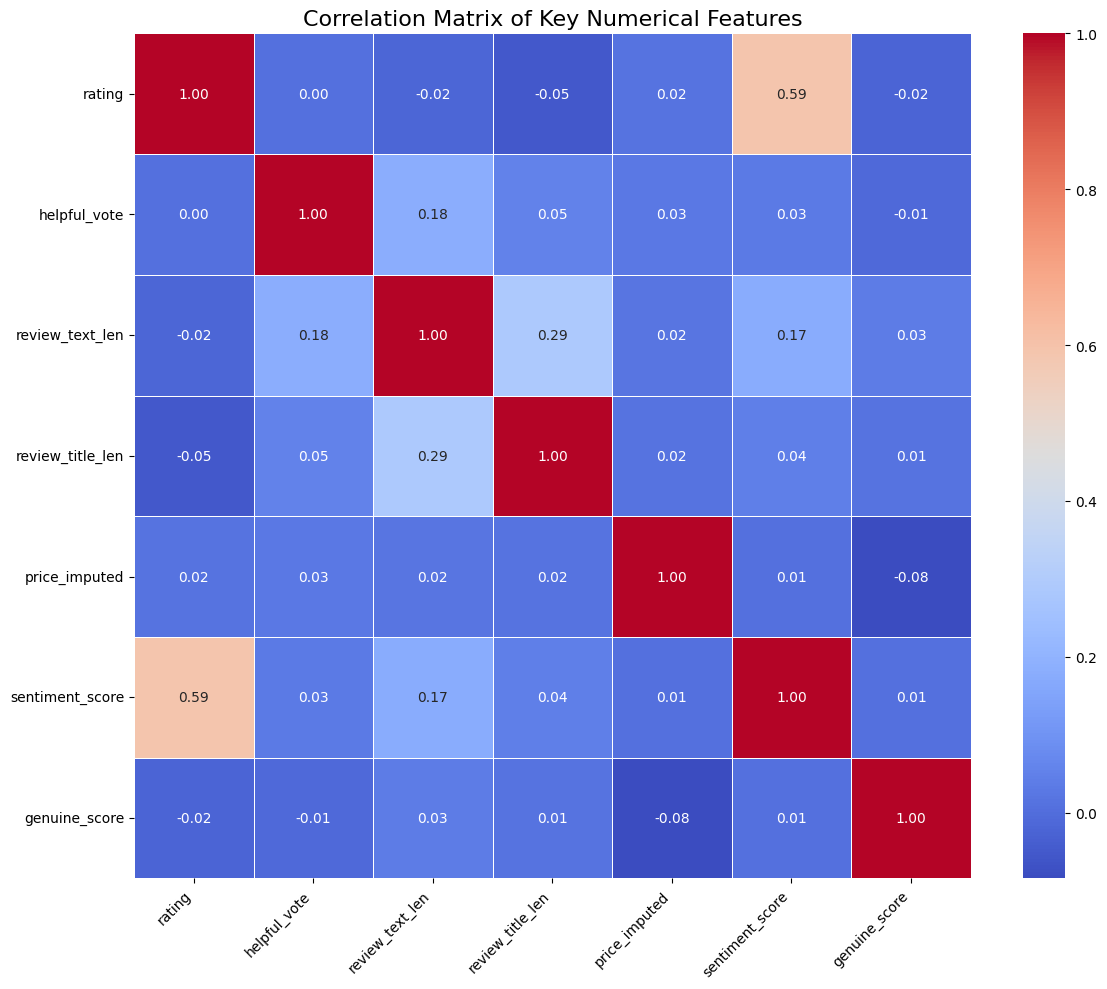

Generated: 1b_numerical_features_correlation_enhanced.png


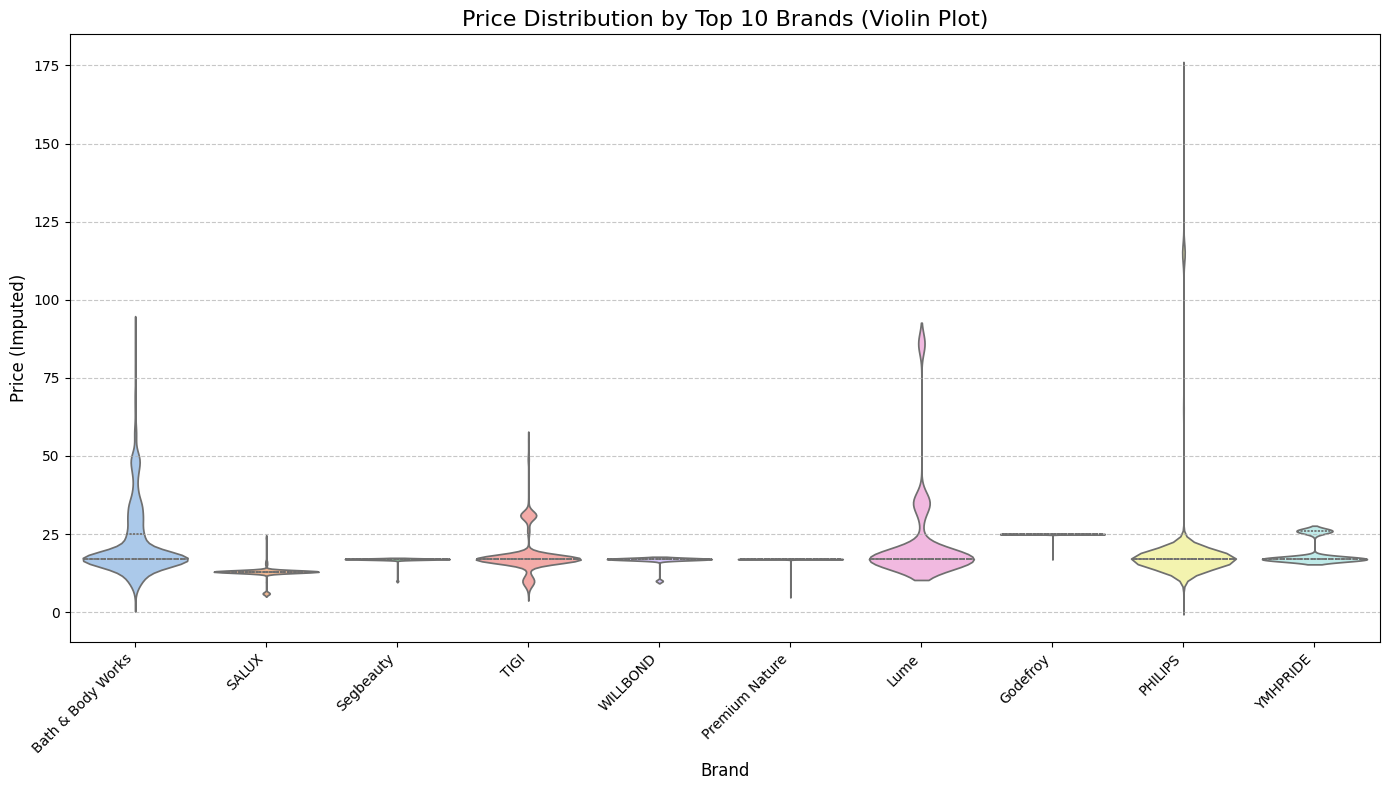

Generated: 1b_price_distribution_by_brand_violin.png


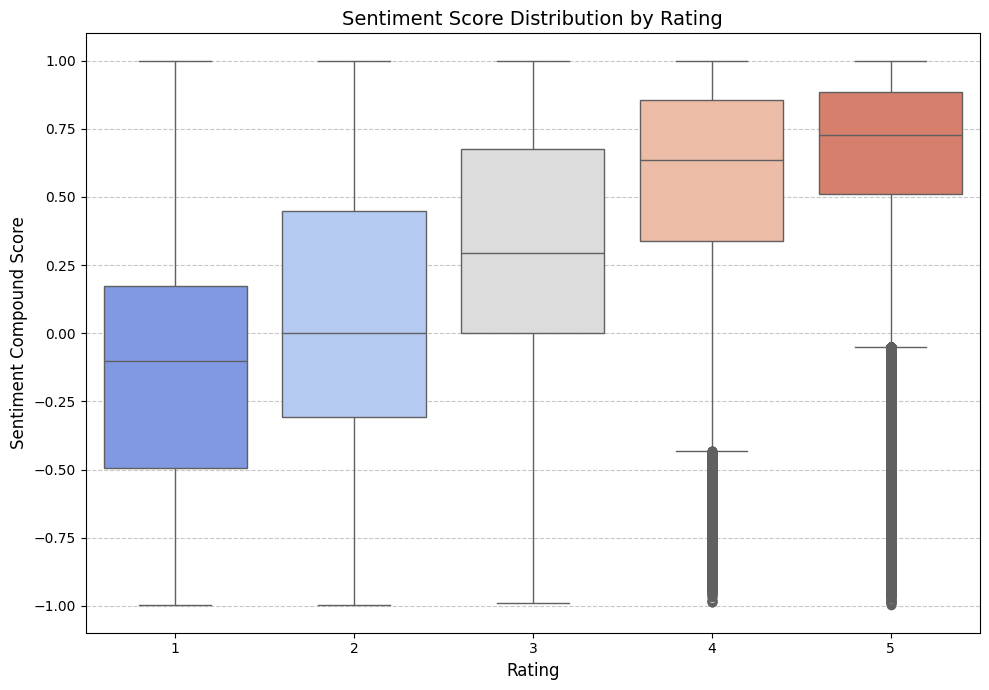

Generated: 1b_sentiment_score_by_rating.png


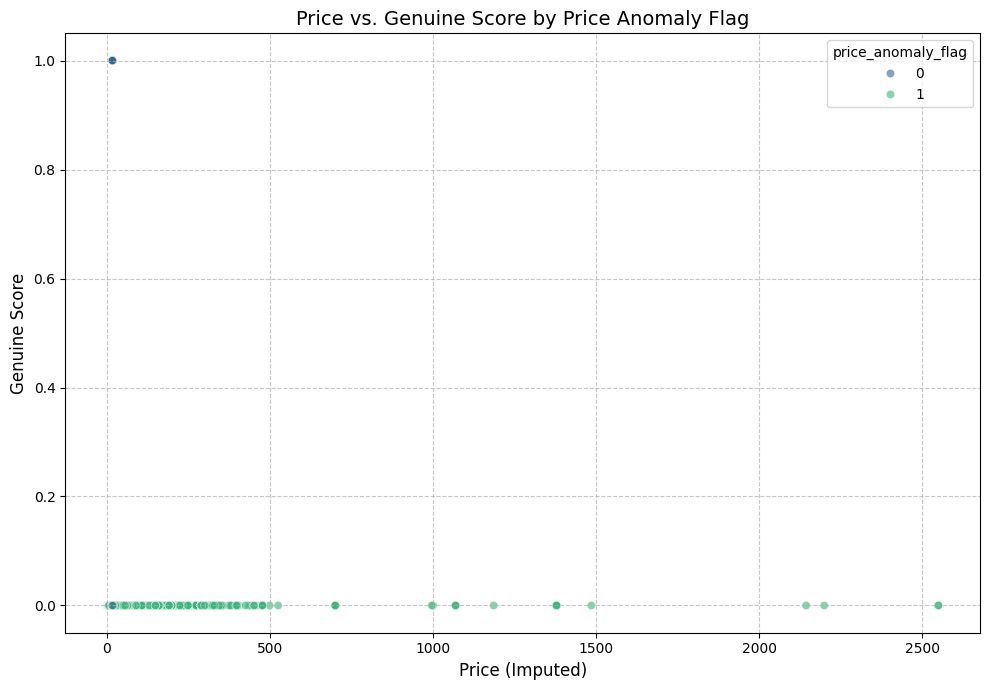

Generated: 1b_price_anomaly_vs_genuine_score.png


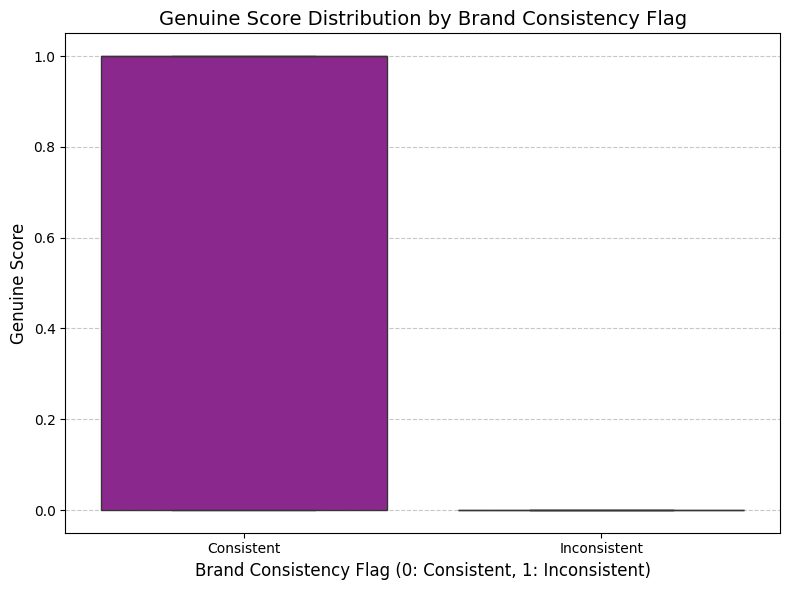

Generated: 1b_brand_consistency_vs_genuine_score.png


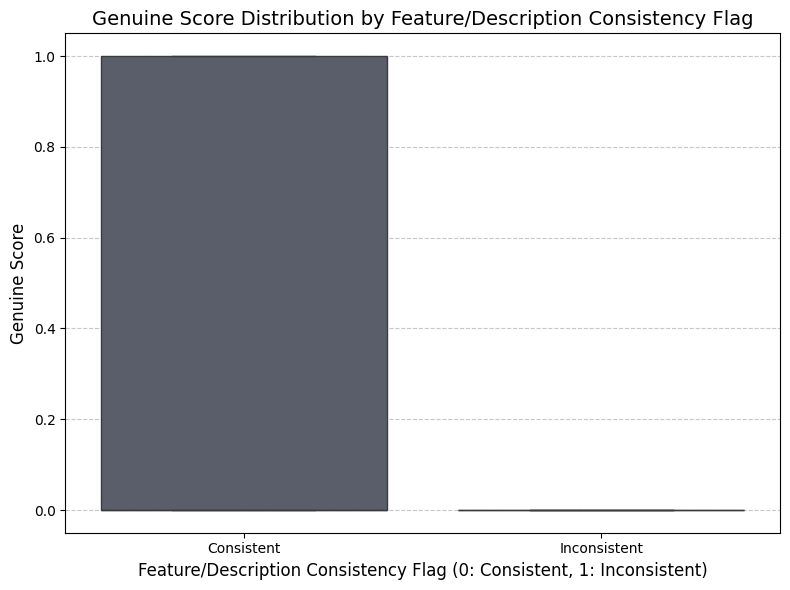

Generated: 1b_feature_description_consistency_vs_genuine_score.png


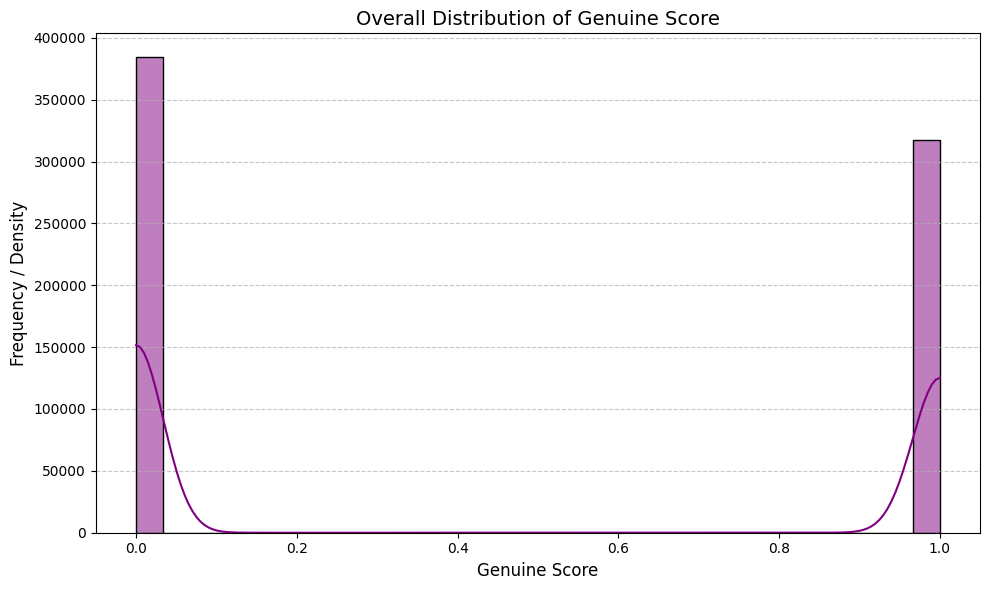

Generated: 1b_overall_genuine_score_distribution.png

All 1B visualizations generated and saved as PNG files.


In [ ]:
# --- 5. Visualization Generation for Assessment 1B ---
print("\n--- 5. Visualization Generation for Assessment 1B ---")

# 5.1. Enhanced Overall Ratings Distribution (with KDE for skew)
plt.figure(figsize=(10, 6))
sns.histplot(df_merged["rating"], bins=5, kde=True, stat="count", palette="viridis")
plt.title("Distribution of Overall Ratings (with Density Estimate)", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frequency / Density", fontsize=12)
plt.xticks(ticks=[1, 2, 3, 4, 5])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("1b_overall_ratings_distribution_kde.png")
plt.close()
print("Generated: 1b_overall_ratings_distribution_kde.png")

# 5.2. Review Text Length Distribution (with log scale for better visibility of long tails)
plt.figure(figsize=(10, 6))
sns.histplot(df_merged["review_text_len"], bins=50, kde=True, log_scale=True, color="skyblue")
plt.title("Distribution of Review Text Length (Log Scale)", fontsize=14)
plt.xlabel("Review Text Length (Log Scale)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("1b_review_text_length_distribution_log.png")
plt.close()
print("Generated: 1b_review_text_length_distribution_log.png")

# 5.3. Correlation Matrix of Numerical Features (Enhanced)
numerical_features_corr = ["rating", "helpful_vote", "review_text_len", "review_title_len", "price_imputed", "sentiment_score", "genuine_score"]
plt.figure(figsize=(12, 10))
sns.heatmap(df_merged[numerical_features_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Key Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
#plt.savefig("1b_numerical_features_correlation_enhanced.png")
plt.close()
print("Generated: 1b_numerical_features_correlation_enhanced.png")

# 5.4. Price Distribution by Top 10 Brands (Violin Plot for richer distribution info)
df_merged_cleaned_store = df_merged.dropna(subset=["store"])
top_brands = df_merged_cleaned_store["store"].value_counts().nlargest(10).index
df_top_brands = df_merged_cleaned_store[df_merged_cleaned_store["store"].isin(top_brands)]
plt.figure(figsize=(14, 8))
sns.violinplot(x="store", y="price_imputed", data=df_top_brands, inner="quartile", palette="pastel")
plt.title("Price Distribution by Top 10 Brands (Violin Plot)", fontsize=16)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Price (Imputed)", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
#plt.savefig("1b_price_distribution_by_brand_violin.png")
plt.show()
plt.close()
print("Generated: 1b_price_distribution_by_brand_violin.png")

# 5.5. Sentiment Score Distribution by Rating (Box Plot)
plt.figure(figsize=(10, 7))
sns.boxplot(x="rating", y="sentiment_score", data=df_merged, palette="coolwarm")
plt.title("Sentiment Score Distribution by Rating", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Sentiment Compound Score", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
#plt.savefig("1b_sentiment_score_by_rating.png")
plt.show()
plt.close()
print("Generated: 1b_sentiment_score_by_rating.png")

# 5.6. Price Anomaly Flag vs. Genuine Score (Scatter Plot with Hue)
plt.figure(figsize=(10, 7))
sns.scatterplot(x="price_imputed", y="genuine_score", hue="price_anomaly_flag", data=df_merged, alpha=0.6, palette="viridis")
plt.title("Price vs. Genuine Score by Price Anomaly Flag", fontsize=14)
plt.xlabel("Price (Imputed)", fontsize=12)
plt.ylabel("Genuine Score", fontsize=12)
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
#plt.savefig("1b_price_anomaly_vs_genuine_score.png")
plt.show()
plt.close()
print("Generated: 1b_price_anomaly_vs_genuine_score.png")

# 5.7. Brand Consistency Flag vs. Genuine Score (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x="brand_consistency_flag", y="genuine_score", data=df_merged, palette="plasma")
plt.title("Genuine Score Distribution by Brand Consistency Flag", fontsize=14)
plt.xlabel("Brand Consistency Flag (0: Consistent, 1: Inconsistent)", fontsize=12)
plt.ylabel("Genuine Score", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Consistent", "Inconsistent"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
#plt.savefig("1b_brand_consistency_vs_genuine_score.png")
plt.show()
plt.close()
print("Generated: 1b_brand_consistency_vs_genuine_score.png")

# 5.8. Feature/Description Consistency Flag vs. Genuine Score (Box Plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x="feature_description_consistency_flag", y="genuine_score", data=df_merged, palette="cividis")
plt.title("Genuine Score Distribution by Feature/Description Consistency Flag", fontsize=14)
plt.xlabel("Feature/Description Consistency Flag (0: Consistent, 1: Inconsistent)", fontsize=12)
plt.ylabel("Genuine Score", fontsize=12)
plt.xticks(ticks=[0, 1], labels=["Consistent", "Inconsistent"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
#plt.savefig("1b_feature_description_consistency_vs_genuine_score.png")
plt.show()
plt.close()
print("Generated: 1b_feature_description_consistency_vs_genuine_score.png")

# 5.9. Overall Genuine Score Distribution (Histogram with KDE)
plt.figure(figsize=(10, 6))
sns.histplot(df_merged["genuine_score"], bins=30, kde=True, color="purple")
plt.title("Overall Distribution of Genuine Score", fontsize=14)
plt.xlabel("Genuine Score", fontsize=12)
plt.ylabel("Frequency / Density", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
#plt.savefig("1b_overall_genuine_score_distribution.png")
plt.show()
plt.close()
print("Generated: 1b_overall_genuine_score_distribution.png")

print("\nAll 1B visualizations generated and saved as PNG files.")